In [1]:
# Import dependencies
import findspark
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import regularizers
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from ann_visualizer.visualize import ann_viz
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Initialize findspark
findspark.init()

# Initialize the spark session
spark = SparkSession.builder.appName("SK_binary_nn").getOrCreate()

In [3]:
# Load in the pre-processed data
s_df = spark.read.csv("../Resources/filtered_encoded_dataset.csv", sep=",", header=True, inferSchema=True)
s_df.show()

+-----------------+--------------------+----------+--------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+------------------+----------------+----------------+----------------+----------------+----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|   primary_artist|          track_name|popularity|explicit|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      duration_min|time_signature_0|time_signature_1|time_signature_3|time_signature_4|time_signature_5|key_0|key_1|key_2|key_3|key_4|key_5|key_6|key_7|key_8|key_9|key_10|key_11|num_artists_binned_1|num_artists_binned_2|num_artists_binned_3|num_artists_binned_4|num_artists_b

In [4]:
# Remove primary_artist and track_name from the dataset
s_df = s_df.drop("primary_artist", "track_name")
s_df.show()

+----------+--------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+------------------+----------------+----------------+----------------+----------------+----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|popularity|explicit|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      duration_min|time_signature_0|time_signature_1|time_signature_3|time_signature_4|time_signature_5|key_0|key_1|key_2|key_3|key_4|key_5|key_6|key_7|key_8|key_9|key_10|key_11|num_artists_binned_1|num_artists_binned_2|num_artists_binned_3|num_artists_binned_4|num_artists_binned_5|num_artists_binned_6|track_genre_0|track_genre_1|track_genre_2|track_g

(array([22457.,  9279., 18354., 14910., 19205., 14532.,  9344.,  4269.,
         1101.,    98.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 10 artists>)

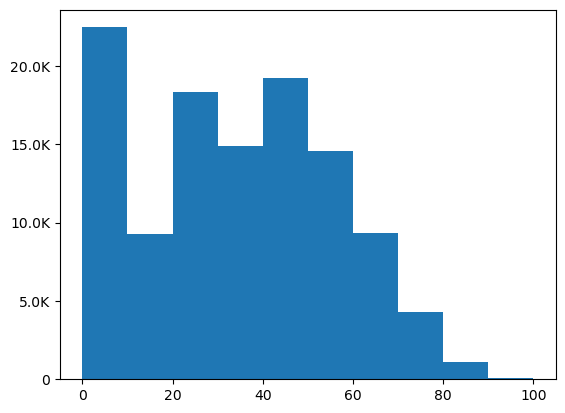

In [5]:
# Check popularity values
fig, ax = plt.subplots()
hist(ax, s_df.select("popularity"))

In [6]:
# Convert the data to a pandas Dataframe
df = s_df.toPandas()
df.head()

,popularity,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,num_artists_binned_4,num_artists_binned_5,num_artists_binned_6,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6
0,73,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,...,0,0,0,0,0,0,0,0,0,1
1,55,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,...,0,0,0,0,0,0,0,0,0,1
2,57,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,...,0,0,0,0,0,0,0,0,0,1
3,71,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,...,0,0,0,0,0,0,0,0,0,1
4,82,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# Show value counts of popularity to help determine proper bins
df['popularity'].value_counts().sort_index()

popularity
0      15843
1       2116
2       1025
3        570
4        377
       ...  
96         7
97         8
98         7
99         1
100        2
Name: count, Length: 101, dtype: int64

In [8]:
## Bin the popularity into: low=0 (pop<=60) or high=1 (60<pop)
# Set up a list of bins
pop_bins = [0, 1]
# Set up list of conditions
pop_conditions = [
    (df["popularity"] <= 60),
    (df["popularity"] > 60)
]
# Set up the column with bins
df["popularity_binned"] = np.select(pop_conditions, pop_bins)

# Confirm binning
df['popularity_binned'].value_counts()

popularity_binned
0    99988
1    13561
Name: count, dtype: int64

In [9]:
# Remove the original popularity column
df.drop(columns="popularity", inplace=True)
# Check removal
df.head()

,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,num_artists_binned_5,num_artists_binned_6,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6,popularity_binned
0,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,...,0,0,0,0,0,0,0,0,1,1
1,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,...,0,0,0,0,0,0,0,0,1,0
2,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,...,0,0,0,0,0,0,0,0,1,0
3,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,...,0,0,0,0,0,0,0,0,1,1
4,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,...,0,0,0,0,0,0,0,0,1,1


In [10]:
# Separate the prediction (song popularity) from the rest of the features
y = df.popularity_binned.values
X = df.drop(columns="popularity_binned")

# Split the training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [11]:
# Create a list for dictionaries to hold the summary and accuracy for each iteration
iterations = []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3440      
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,541
Trainable params: 7,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2662/2662 [==============================] - 3s 834us/step - loss: 0.3356 - accuracy: 0.8806 - val_loss: 0.3193 - val_accuracy: 0.8809
Epoch 2/100
2662/2662 [==============================] - 2s 731us/step - loss: 0.3094 - accuracy: 0.8840 - val_loss: 0.3016 - val_accuracy: 0.8856
Epoch 3/100
2662/2662 [=

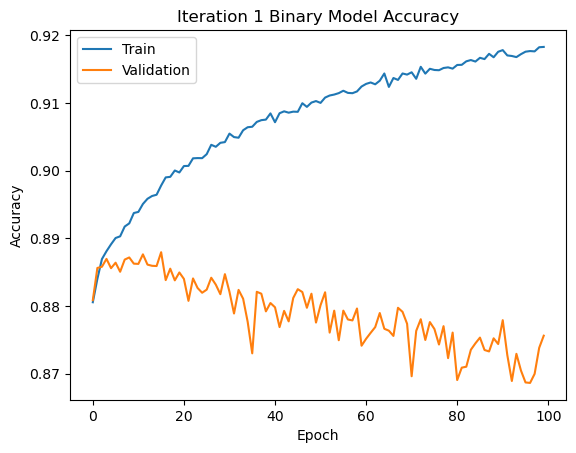

In [12]:
### Iteration 1: binary population but no other changes to the data processing, with Standard Scaler normalization
# Create a dictionary for iteration 1
iteration_1 = {} 

# Add the iteration
iteration_1["Iteration"] = 1

# Create a StandardScaler instance
scaler1 = StandardScaler()

# Fit the scaler
X_scaler_1 = scaler1.fit(X_train)

# Scale the data
X_train_scaled_1 = X_scaler_1.transform(X_train)
X_test_scaled_1 = X_scaler_1.transform(X_test)

# Define the model
nn_1 = tf.keras.models.Sequential()

# First hidden layer
nn_1.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_1.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check model structure
nn_1.summary()

# Compile the model
nn_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_1 = nn_1.fit(X_train_scaled_1, y_train, epochs=100, validation_data=(X_test_scaled_1, y_test), shuffle=True)

# Evaluate the model
model_loss_1, model_accuracy_1 = nn_1.evaluate(X_test_scaled_1, y_test, verbose=2)

# Add the evaluation to the iteration_1 dictionary
iteration_1["Loss"] = model_loss_1
iteration_1["Accuracy"] = model_accuracy_1

# Add the iteration_1 dictionary to the iterations list
iterations.append(iteration_1)

# Plot the accuracy over each epoch of training the final model
plt.plot(model_1.history['accuracy'])
plt.plot(model_1.history['val_accuracy'])
plt.title('Iteration 1 Binary Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("summary_stats/iteration1_binary_training_accuracy.svg")
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 80)                3440      
                                                                 
 dense_4 (Dense)             (None, 50)                4050      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,541
Trainable params: 7,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2662/2662 [==============================] - 2s 748us/step - loss: 0.3385 - accuracy: 0.8796 - val_loss: 0.3201 - val_accuracy: 0.8818
Epoch 2/100
2662/2662 [==============================] - 2s 727us/step - loss: 0.3061 - accuracy: 0.8845 - val_loss: 0.2953 - val_accuracy: 0.8859
Epoch 3/100
2662/2662 

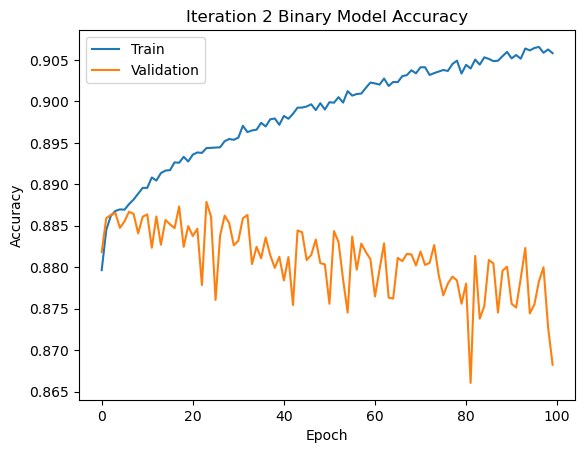

In [13]:
### Iteration 2: Same as above, but Min Max normalization
# Create a dictionary for iteration 2
iteration_2 = {} 

# Add the iteration
iteration_2["Iteration"] = 2

# Create a MinMaxScaler instance
scaler2 = MinMaxScaler()

# Fit the scaler
X_scaler_2 = scaler2.fit(X_train)

# Scale the data
X_train_scaled_2 = X_scaler_2.transform(X_train)
X_test_scaled_2 = X_scaler_2.transform(X_test)

# Define the model
nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check model structure
nn_2.summary()

# Compile the model
nn_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_2 = nn_2.fit(X_train_scaled_2, y_train, epochs=100, validation_data=(X_test_scaled_2, y_test), shuffle=True)

# Evaluate the model
model_loss_2, model_accuracy_2 = nn_2.evaluate(X_test_scaled_2, y_test, verbose=2)

# Add the evaluation to the iteration_2 dictionary
iteration_2["Loss"] = model_loss_2
iteration_2["Accuracy"] = model_accuracy_2

# Add the iteration_2 dictionary to the iterations list
iterations.append(iteration_2)

# Plot the accuracy over each epoch of training the final model
plt.plot(model_2.history['accuracy'])
plt.plot(model_2.history['val_accuracy'])
plt.title('Iteration 2 Binary Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("summary_stats/iteration2_binary_training_accuracy.svg")
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 80)                3440      
                                                                 
 dense_7 (Dense)             (None, 50)                4050      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,541
Trainable params: 7,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4687/4687 [==============================] - 3s 663us/step - loss: 0.5474 - accuracy: 0.7141 - val_loss: 0.4650 - val_accuracy: 0.7372
Epoch 2/100
4687/4687 [==============================] - 3s 650us/step - loss: 0.4761 - accuracy: 0.7682 - val_loss: 0.4621 - val_accuracy: 0.7379
Epoch 3/100
4687/4687 

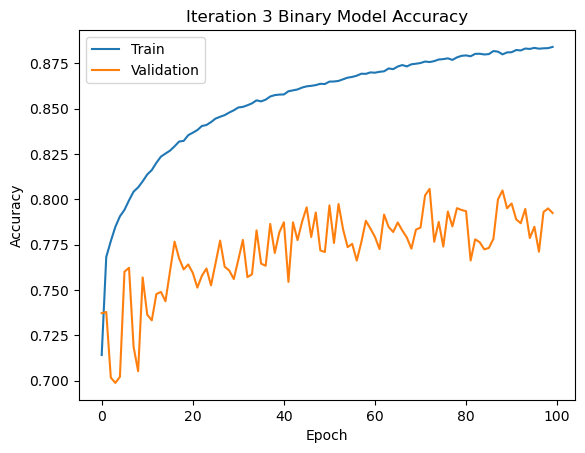

In [14]:
### Iteration 3: Same as above, but adds random oversampling to adjust for skewed data
# Create a dictionary for iteration 3
iteration_3 = {} 

# Add the iteration
iteration_3["Iteration"] = 3

# Create a MinMaxScaler instance
scaler3 = MinMaxScaler()

# Fit the scaler
X_scaler_3 = scaler3.fit(X_train)

# Scale the data
X_train_scaled_3 = X_scaler_3.transform(X_train)
X_test_scaled_3 = X_scaler_3.transform(X_test)

# Instantiate random oversampler model
ros_3 = RandomOverSampler(random_state=1)

# Fit the training data to the oversampler model
X_ros_3, y_ros_3 = ros_3.fit_resample(X_train_scaled_3, y_train)

# Define the model
nn_3 = tf.keras.models.Sequential()

# First hidden layer
nn_3.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_3.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check model structure
nn_3.summary()

# Compile the model
nn_3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_3 = nn_3.fit(X_ros_3, y_ros_3, epochs=100, validation_data=(X_test_scaled_3, y_test), shuffle=True)

# Evaluate the model
model_loss_3, model_accuracy_3 = nn_3.evaluate(X_test_scaled_3, y_test, verbose=2)

# Add the evaluation to the iteration_3 dictionary
iteration_3["Loss"] = model_loss_3
iteration_3["Accuracy"] = model_accuracy_3

# Add the iteration_3 dictionary to the iterations list
iterations.append(iteration_3)

# Plot the accuracy over each epoch of training the final model
plt.plot(model_3.history['accuracy'])
plt.plot(model_3.history['val_accuracy'])
plt.title('Iteration 3 Binary Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("summary_stats/iteration3_binary_training_accuracy.svg")
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 80)                3440      
                                                                 
 dense_10 (Dense)            (None, 50)                4050      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 7,541
Trainable params: 7,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4687/4687 [==============================] - 4s 710us/step - loss: 0.5519 - accuracy: 0.7098 - val_loss: 0.5217 - val_accuracy: 0.6993
Epoch 2/100
4687/4687 [==============================] - 3s 657us/step - loss: 0.4792 - accuracy: 0.7658 - val_loss: 0.4766 - val_accuracy: 0.7286
Epoch 3/100
4687/4687 

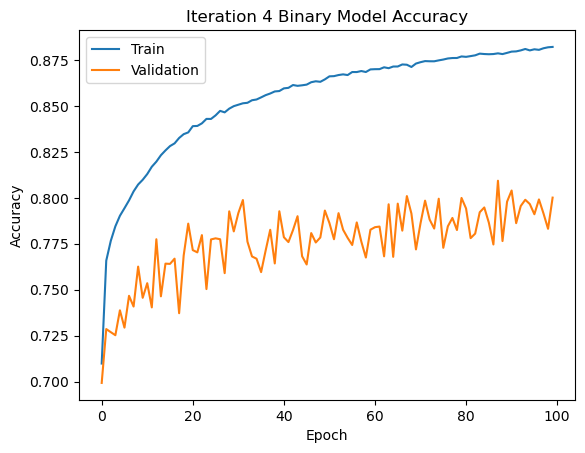

In [15]:
### Iteration 4: Same as above, but scaling only applied to the columns that are NOT either binary or already between 0 and 1
# Create a dictionary for iteration 4
iteration_4 = {} 

# Add the iteration
iteration_4["Iteration"] = 4

# Create a MinMaxScaler instance
scaler4 = MinMaxScaler()

# Fit the scaler
X_scaler_4 = scaler4.fit(X_train[["loudness", "tempo", "duration_min"]])

# Scale the data
X_train_scaled_4 = X_train
X_train_scaled_4[["loudness", "tempo", "duration_min"]] = X_scaler_4.transform(X_train[["loudness", "tempo", "duration_min"]])
X_test_scaled_4 = X_test
X_test_scaled_4[["loudness", "tempo", "duration_min"]] = X_scaler_4.transform(X_test[["loudness", "tempo", "duration_min"]])

# Instantiate random oversampler model
ros_4 = RandomOverSampler(random_state=1)

# Fit the training data to the oversampler model
X_ros_4, y_ros_4 = ros_4.fit_resample(X_train_scaled_4, y_train)

# Define the model
nn_4 = tf.keras.models.Sequential()

# First hidden layer
nn_4.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_4.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check model structure
nn_4.summary()

# Compile the model
nn_4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_4 = nn_4.fit(X_ros_4, y_ros_4, epochs=100, validation_data=(X_test_scaled_4, y_test), shuffle=True)

# Evaluate the model
model_loss_4, model_accuracy_4 = nn_4.evaluate(X_test_scaled_4, y_test, verbose=2)

# Add the evaluation to the iteration_4 dictionary
iteration_4["Loss"] = model_loss_4
iteration_4["Accuracy"] = model_accuracy_4

# Add the iteration_4 dictionary to the iterations list
iterations.append(iteration_4)

# Plot the accuracy over each epoch of training the final model
plt.plot(model_4.history['accuracy'])
plt.plot(model_4.history['val_accuracy'])
plt.title('Iteration 4 Binary Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("summary_stats/iteration4_binary_training_accuracy.svg")
plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 25)                1075      
                                                                 
 dense_13 (Dense)            (None, 20)                520       
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,616
Trainable params: 1,616
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4687/4687 [==============================] - 4s 679us/step - loss: 0.6839 - accuracy: 0.6356 - val_loss: 0.6582 - val_accuracy: 0.6179
Epoch 2/100
4687/4687 [==============================] - 3s 658us/step - loss: 0.6342 - accuracy: 0.6684 - val_loss: 0.6585 - val_accuracy: 0.6111
Epoch 3/100
4687/4687 

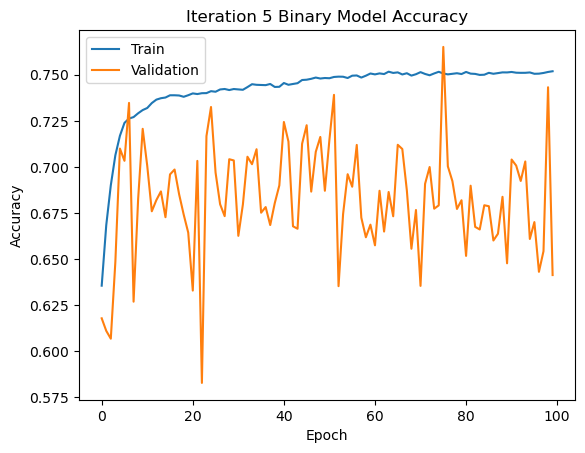

In [16]:
### Iteration 5: Same as above, but decrease the number of nodes and add a regularizer to try to reduce overfitting
# Create a dictionary for iteration 5
iteration_5 = {} 

# Add the iteration
iteration_5["Iteration"] = 5

# Create a MinMaxScaler instance
scaler5 = MinMaxScaler()

# Fit the scaler
X_scaler_5 = scaler5.fit(X_train[["loudness", "tempo", "duration_min"]])

# Scale the data
X_train_scaled_5 = X_train
X_train_scaled_5[["loudness", "tempo", "duration_min"]] = X_scaler_5.transform(X_train[["loudness", "tempo", "duration_min"]])
X_test_scaled_5 = X_test
X_test_scaled_5[["loudness", "tempo", "duration_min"]] = X_scaler_5.transform(X_test[["loudness", "tempo", "duration_min"]])

# Instantiate random oversampler model
ros_5 = RandomOverSampler(random_state=1)

# Fit the training data to the oversampler model
X_ros_5, y_ros_5 = ros_5.fit_resample(X_train_scaled_5, y_train)

# Define the model
nn_5 = tf.keras.models.Sequential()

# First hidden layer
nn_5.add(tf.keras.layers.Dense(units=25, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_dim=42))

# Second hidden layer
nn_5.add(tf.keras.layers.Dense(units=20, kernel_regularizer=regularizers.l1(0.001), activation="relu"))

# Output layer
nn_5.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check model structure
nn_5.summary()

# Compile the model
nn_5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_5 = nn_5.fit(X_ros_5, y_ros_5, epochs=100, validation_data=(X_test_scaled_5, y_test), shuffle=True)

# Evaluate the model
model_loss_5, model_accuracy_5 = nn_5.evaluate(X_test_scaled_5, y_test, verbose=2)

# Add the evaluation to the iteration_5 dictionary
iteration_5["Loss"] = model_loss_5
iteration_5["Accuracy"] = model_accuracy_5

# Add the iteration_5 dictionary to the iterations list
iterations.append(iteration_5)

# Plot the accuracy over each epoch of training the final model
plt.plot(model_5.history['accuracy'])
plt.plot(model_5.history['val_accuracy'])
plt.title('Iteration 5 Binary Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("summary_stats/iteration5_binary_training_accuracy.svg")
plt.show()

In [17]:
# Visualize the model structure (this is the same for iterations 1-4 so is only done once, and 4 works better than 5)
ann_viz(nn_4, title="Binary Popularity Testing Structure", filename="summary_stats/binary_popularity_testing_nn_structure.gv", view=True)

In [19]:
### Iteration 6: Same as above, but with hyperparameter tuning to find best parameters
# Create a dictionary for iteration 6
iteration_6 = {} 

# Add the iteration
iteration_6["Iteration"] = 6

# Create a MinMaxScaler instance
scaler6 = MinMaxScaler()

# Fit the scaler
X_scaler_6 = scaler6.fit(X_train[["loudness", "tempo", "duration_min"]])

# Scale the data
X_train_scaled_6 = X_train
X_train_scaled_6[["loudness", "tempo", "duration_min"]] = X_scaler_6.transform(X_train[["loudness", "tempo", "duration_min"]])
X_test_scaled_6 = X_test
X_test_scaled_6[["loudness", "tempo", "duration_min"]] = X_scaler_6.transform(X_test[["loudness", "tempo", "duration_min"]])

# Instantiate random oversampler model
ros_6 = RandomOverSampler(random_state=1)

# Fit the training data to the oversampler model
X_ros_6, y_ros_6 = ros_6.fit_resample(X_train_scaled_6, y_train)

# Create a method that creates a Sequential model with hyperparameter tuning
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Determine the activation functions for each layer
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Determine neurons in the first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units', 
        min_value=80, 
        max_value=120, 
        step=20), 
        activation=activation, input_dim=42))
    
    # Determine the number of hidden layers and neurons in them
    for i in range(hp.Int('num_layers', 2, 4)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_'+str(i),
            min_value=50, 
            max_value=90,
            step=20),
            activation=activation))
    
    # Set up the output layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return nn_model

# Set up the kerastuner instance
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy", 
    max_epochs=20, 
    hyperband_iterations=2,
    overwrite=True)

# Run the kerastuner
tuner.search(X_ros_6, y_ros_6, epochs=20, validation_data=(X_test_scaled_6, y_test))

Trial 60 Complete [00h 01m 19s]
val_accuracy: 0.7906509637832642

Best val_accuracy So Far: 0.796956479549408
Total elapsed time: 00h 28m 20s
INFO:tensorflow:Oracle triggered exit


In [20]:
### Iteration 6 continued
# Get the best model and show its parameters
best_hyper = tuner.get_best_hyperparameters(1)
for params in best_hyper:
    print(params.values)

# Get a summary of the best model
best_model = tuner.get_best_models()
best_model[0].summary()

# Build the best model and train it on the data
model = tuner.hypermodel.build(best_hyper[0])
history = model.fit(X_ros_6, y_ros_6, epochs=100, validation_data=(X_test_scaled_6, y_test), shuffle=True)

# Evaluate the model
model_loss_6, model_accuracy_6 = model.evaluate(X_test_scaled_6, y_test, verbose=2)

# Add the evaluation to the iteration_6 dictionary
iteration_6["Loss"] = model_loss_6
iteration_6["Accuracy"] = model_accuracy_6

# Add the iteration_6 dictionary to the iterations list
iterations.append(iteration_6)

{'activation': 'tanh', 'first_units': 120, 'num_layers': 2, 'units_0': 90, 'units_1': 90, 'units_2': 50, 'units_3': 90, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0053'}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               5160      
                                                                 
 dense_1 (Dense)             (None, 90)                10890     
                                                                 
 dense_2 (Dense)             (None, 90)                8190      
                                                                 
 dense_3 (Dense)             (None, 1)                 91        
                                                                 
Total params: 24,331
Trainable params: 24,331
Non-trainable params: 0
____________________

In [21]:
# Save the final hypertuned model
model.save("binary_popularity_model.h5")

In [22]:
# Visualize the final model structure
ann_viz(model, title="Binary Popularity Final Structure", filename="summary_stats/binary_popularity_final_nn_structure.gv", view=True)

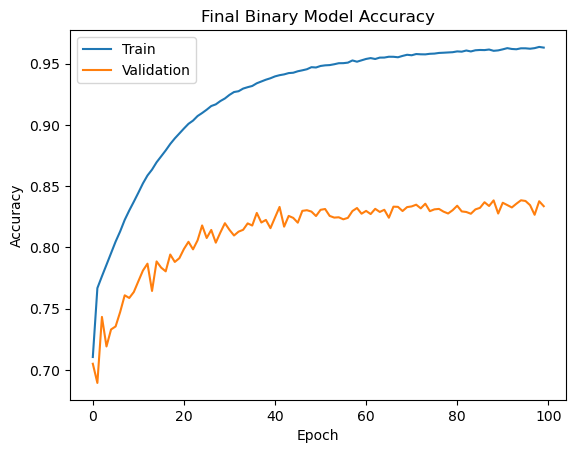

In [23]:
# Plot the accuracy over each epoch of training the final model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final Binary Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("summary_stats/final_binary_training_accuracy.svg")
plt.show()

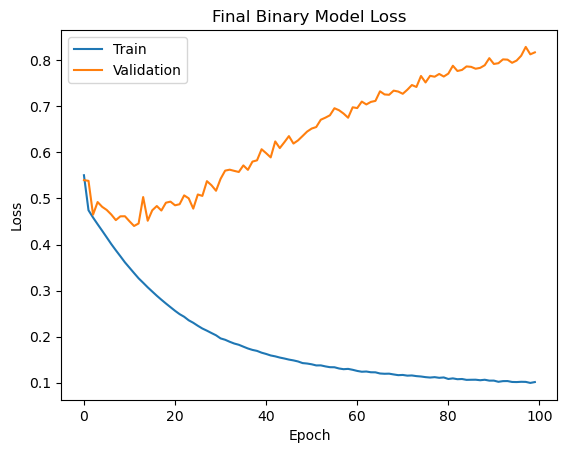

In [24]:
# Plot the loss over each epoch of training the final model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final Binary Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("summary_stats/final_binary_training_loss.svg")
plt.show()

In [25]:
# Add final statistics to a dataframe, show the dataframe, and output to a csv
stats_df = pd.DataFrame(iterations)
stats_df[['Accuracy', 'Loss']] = stats_df[['Accuracy', 'Loss']].round(3)
stats_df.to_csv("summary_stats/binary_popularity_stats.csv", index=False)
stats_df

,Iteration,Loss,Accuracy
0,1,0.345,0.876
1,2,0.319,0.868
2,3,0.544,0.793
3,4,0.513,0.800
4,5,0.626,0.641
5,6,0.818,0.834
